In [1]:
import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv('Insurance claims data.csv')

# Afficher les premières lignes
print("=== Structure initiale des données ===")
print(df.head())

=== Structure initiale des données ===
   policy_id  subscription_length  vehicle_age  customer_age region_code  \
0  POL045360                  9.3          1.2            41          C8   
1  POL016745                  8.2          1.8            35          C2   
2  POL007194                  9.5          0.2            44          C8   
3  POL018146                  5.2          0.4            44         C10   
4  POL049011                 10.1          1.0            56         C13   

   region_density segment model fuel_type     max_torque  ... is_brake_assist  \
0            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
1           27003      C1    M9    Diesel  200Nm@1750rpm  ...              No   
2            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
3           73430       A    M1       CNG   60Nm@3500rpm  ...              No   
4            5410      B2    M5    Diesel  200Nm@3000rpm  ...              No   

  is_power_door_l

In [2]:
print("\n=== Informations générales ===")
print(df.info())



=== Informations générales ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26063 entries, 0 to 26062
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         26063 non-null  object 
 1   subscription_length               26063 non-null  float64
 2   vehicle_age                       26063 non-null  float64
 3   customer_age                      26063 non-null  int64  
 4   region_code                       26063 non-null  object 
 5   region_density                    26063 non-null  int64  
 6   segment                           26063 non-null  object 
 7   model                             26063 non-null  object 
 8   fuel_type                         26063 non-null  object 
 9   max_torque                        26063 non-null  object 
 10  max_power                         26063 non-null  object 
 11  engine_type                       2

In [3]:
print("\n=== Statistiques descriptives ===")
print(df.describe(include='all'))


=== Statistiques descriptives ===
        policy_id  subscription_length   vehicle_age  customer_age  \
count       26063         26063.000000  26063.000000  26063.000000   
unique      26063                  NaN           NaN           NaN   
top     POL050088                  NaN           NaN           NaN   
freq            1                  NaN           NaN           NaN   
mean          NaN             6.094264      1.387676     44.824464   
std           NaN             4.145791      1.133409      6.941792   
min           NaN             0.000000      0.000000     35.000000   
25%           NaN             2.100000      0.400000     39.000000   
50%           NaN             5.700000      1.200000     44.000000   
75%           NaN            10.400000      2.200000     49.000000   
max           NaN            13.900000     20.000000     73.000000   

       region_code  region_density segment  model fuel_type     max_torque  \
count        26063    26063.000000   26063  26

In [4]:
# Supprimer la colonne d'identification
df.drop('policy_id', axis=1, inplace=True)

# Convertir les colonnes binaires
binary_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0)

print("\n=== Après conversion des colonnes binaires ===")
print(df[binary_cols].head())


=== Après conversion des colonnes binaires ===
   is_esc  is_adjustable_steering  is_tpms  is_parking_sensors  \
0       1                       1        1                   1   
1       0                       1        0                   1   
2       1                       1        1                   1   
3       0                       0        0                   1   
4       0                       1        0                   1   

   is_parking_camera  rear_brakes_type  transmission_type  \
0                  1               0.0                0.0   
1                  1               0.0                0.0   
2                  1               0.0                0.0   
3                  0               0.0                0.0   
4                  0               0.0                0.0   

   is_front_fog_lights  is_rear_window_wiper  is_rear_window_washer  \
0                  1.0                   1.0                    1.0   
1                  1.0                   0.0  

In [5]:
def clean_engine_features(df):
    # Extraction couple moteur
    torque_split = df['max_torque'].str.extract(r'(\d+\.?\d*)Nm@(\d+)rpm')
    df['max_torque_value'] = torque_split[0].astype(float)
    df['max_torque_rpm'] = torque_split[1].astype(float)

    # Extraction puissance moteur
    power_split = df['max_power'].str.extract(r'(\d+\.?\d*)(bhp|kW|PS)@(\d+)rpm')
    df['max_power_value'] = power_split[0].astype(float)

    # Conversion unités de puissance
    power_conversion = {'bhp': 1, 'kW': 1.341, 'PS': 0.9863}
    df['max_power_value'] = df['max_power_value'] * power_split[1].map(power_conversion).fillna(1)
    df['max_power_rpm'] = power_split[2].astype(float)

    return df.drop(['max_torque', 'max_power'], axis=1)

df = clean_engine_features(df)
print("\n=== Après extraction des caractéristiques moteur ===")
print(df[['max_torque_value', 'max_torque_rpm', 'max_power_value', 'max_power_rpm']].head())


=== Après extraction des caractéristiques moteur ===
   max_torque_value  max_torque_rpm  max_power_value  max_power_rpm
0             250.0          2750.0           113.45         4000.0
1             200.0          1750.0            97.89         3600.0
2             250.0          2750.0           113.45         4000.0
3              60.0          3500.0            40.36         6000.0
4             200.0          3000.0            88.77         4000.0


In [6]:
# Vérification initiale
print("\n=== Valeurs manquantes avant traitement ===")
print(df.isna().sum())

# Imputation numérique (médiane)
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Imputation catégorielle (mode)
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\n=== Valeurs manquantes après traitement ===")
print(df.isna().sum())


=== Valeurs manquantes avant traitement ===
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            1
transmission_type                   0
steering_type                       1
turning_radius                      1
length                              1
width                               1
gross_weight                        1
is_front_fog_lights                 0
is_re

In [7]:
# Suppression des doublons
initial_count = len(df)
df = df.drop_duplicates()
final_count = len(df)

print(f"\nDoublons supprimés : {initial_count - final_count}")
print(f"Pourcentage de données conservées : {final_count/initial_count:.2%}")


Doublons supprimés : 434
Pourcentage de données conservées : 98.33%



=== Rapport final de nettoyage ===
Colonnes initiales : 41
Colonnes finales : 42
Lignes initiales : 26063
Lignes finales : 25629
Types de données finaux :
float64    27
int64       9
object      6
Name: count, dtype: int64


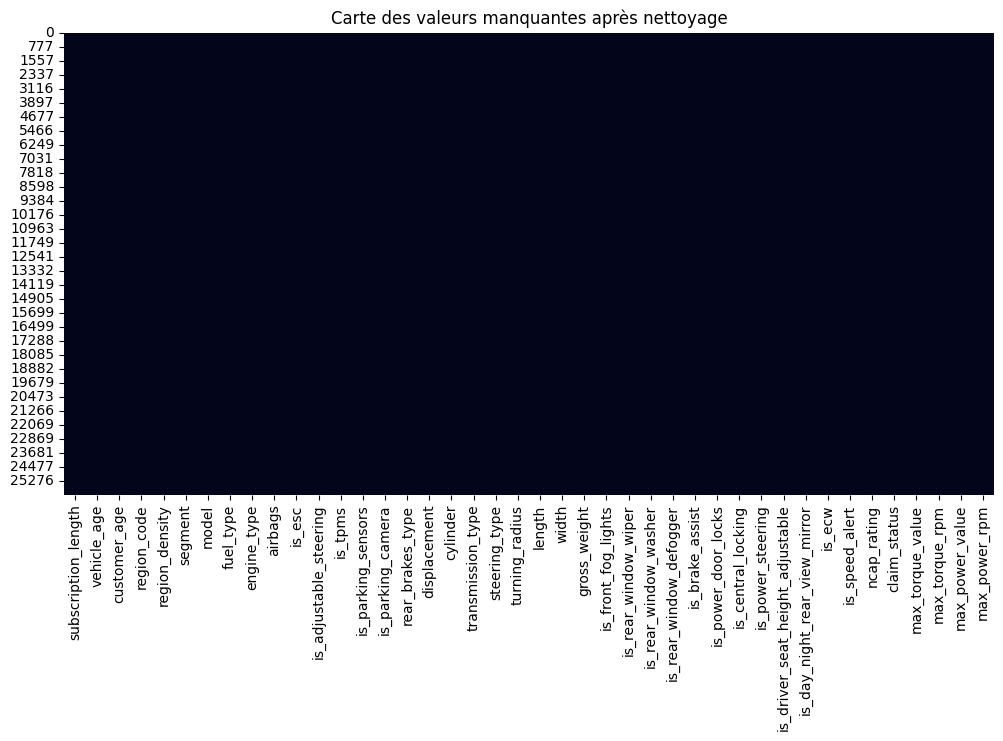

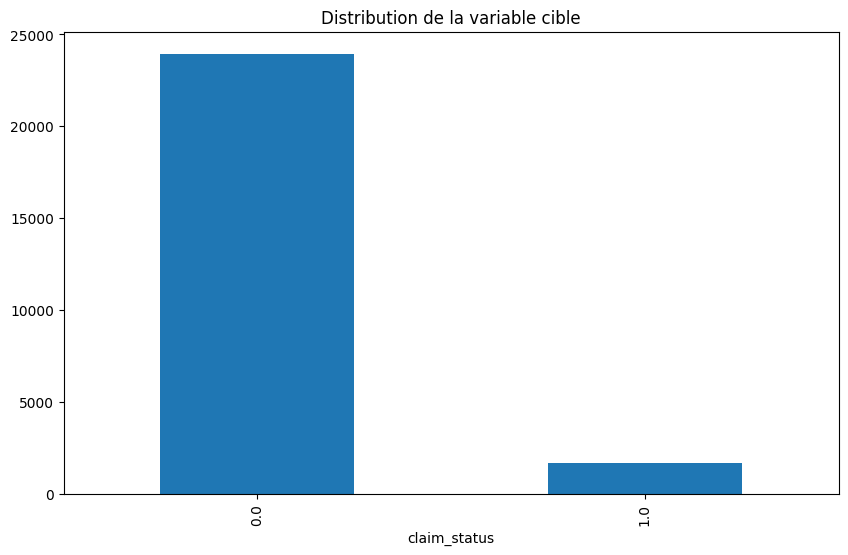

In [8]:
# Résumé de nettoyage
print("\n=== Rapport final de nettoyage ===")
print(f"Colonnes initiales : 41\nColonnes finales : {len(df.columns)}")
print(f"Lignes initiales : {initial_count}\nLignes finales : {final_count}")
print("Types de données finaux :")
print(df.dtypes.value_counts())

# Vérification visuelle
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Carte des valeurs manquantes après nettoyage')
plt.show()

plt.figure(figsize=(10, 6))
df['claim_status'].value_counts().plot(kind='bar')
plt.title('Distribution de la variable cible')
plt.show()

In [9]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from imblearn.over_sampling import SMOTE

# # Séparer les variables explicatives et la cible
# X = df.drop('claim_status', axis=1)
# y = df['claim_status']

# # Identifier les colonnes numériques et catégorielles
# numerical_cols = X.select_dtypes(include='number').columns
# categorical_cols = X.select_dtypes(include='object').columns

# # Pipeline de prétraitement
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), numerical_cols),
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
# ])

# # Split en jeu d'entraînement/test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Appliquer le prétraitement
# X_train_prep = preprocessor.fit_transform(X_train)
# X_test_prep = preprocessor.transform(X_test)

# # Appliquer SMOTE uniquement sur le jeu d'entraînement
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_prep, y_train)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# === 1. Séparer les variables explicatives et la cible ===
X = df.drop('claim_status', axis=1)
y = df['claim_status']

# === 2. Identifier les colonnes numériques et catégorielles ===
numerical_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(include='object').columns

# === 3. Pipeline de prétraitement ===
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# === 4. Split global en train/test ===
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 5. Prétraitement ===
X_train_prepped = preprocessor.fit_transform(X_train_base)
X_test_prepped = preprocessor.transform(X_test_base)

# === 6. Données pour Decision Tree (sans SMOTE) ===
X_train_tree = X_train_prepped
X_test_tree = X_test_prepped
y_train_tree = y_train_base
y_test_tree = y_test_base

# === 7. Données pour KNN (avec SMOTE) ===
smote = SMOTE(random_state=42)
X_train_knn, y_train_knn = smote.fit_resample(X_train_prepped, y_train_base)
X_test_knn = X_test_prepped
y_test_knn = y_test_base



In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# === Initialiser le modèle KNN ===
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    metric='manhattan'
)

# === Entraîner sur les données équilibrées (SMOTE) ===
knn.fit(X_train_knn, y_train_knn)

# === Prédire sur le jeu de test original ===
y_pred = knn.predict(X_test_knn)
y_scores = knn.predict_proba(X_test_knn)[:, 1]  # Pour ROC AUC

# === Rapport de performance ===
print("\n=== Rapport de classification (KNN) ===")
print(classification_report(y_test_knn, y_pred))

print("\n=== Matrice de confusion (KNN) ===")
print(confusion_matrix(y_test_knn, y_pred))

# === Score AUC (facultatif) ===
print("\nAUC (KNN):", roc_auc_score(y_test_knn, y_scores))




=== Rapport de classification (KNN) ===
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      4791
         1.0       0.07      0.17      0.09       335

    accuracy                           0.78      5126
   macro avg       0.50      0.50      0.49      5126
weighted avg       0.88      0.78      0.83      5126


=== Matrice de confusion (KNN) ===
[[3961  830]
 [ 277   58]]

AUC (KNN): 0.5042386688972171


In [28]:
print(X_test_knn[0])

[-1.23564362  0.18002414 -0.83741686  3.0914239  -0.61416724 -0.67349686
  0.80499605 -0.55866629  0.21138974 -0.800396    0.          0.12801793
  0.76730961  0.         -0.23218882 -0.01887617  0.5605792  -0.23715396
  0.85187821 -0.6335893  -0.6335893  -0.73010218  0.90494854  0.61359774
  0.61359774  0.15233486  0.84152023  1.26553285  0.61359774  0.07768738
  0.17014407 -0.29265708  1.18662632  0.34316703  0.75413909  0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          

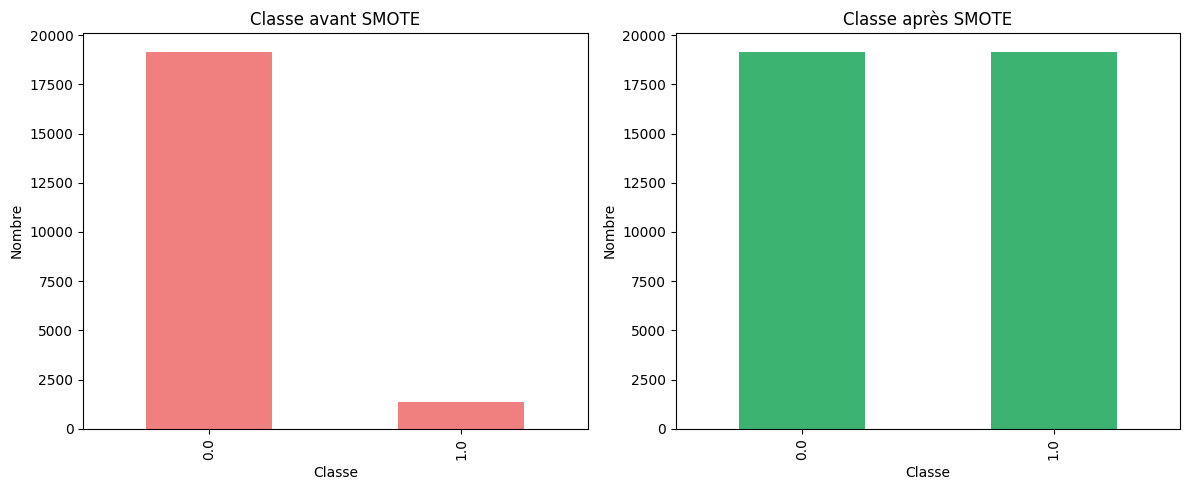

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Visualiser la distribution de la cible avant/après SMOTE
plt.figure(figsize=(12, 5))

# Avant SMOTE
plt.subplot(1, 2, 1)
y_train_base.value_counts().plot(kind='bar', color='lightcoral')
plt.title('Classe avant SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre')

# Après SMOTE
plt.subplot(1, 2, 2)
pd.Series(y_train_knn).value_counts().plot(kind='bar', color='mediumseagreen')
plt.title('Classe après SMOTE')
plt.xlabel('Classe')
plt.ylabel('Nombre')

plt.tight_layout()
plt.show()



In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Scores for KNN model
print("Accuracy :", accuracy_score(y_test_knn, y_pred))
print("Precision:", precision_score(y_test_knn, y_pred))
print("Recall   :", recall_score(y_test_knn, y_pred))
print("F1 Score :", f1_score(y_test_knn, y_pred))


Accuracy : 0.7840421381193914
Precision: 0.06531531531531531
Recall   : 0.17313432835820897
F1 Score : 0.09484873262469337


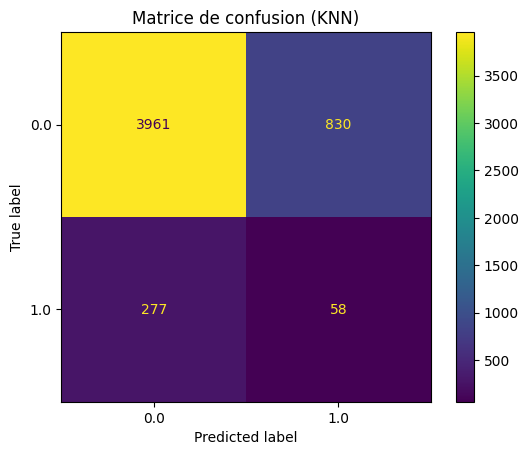

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Show confusion matrix using the KNN model
ConfusionMatrixDisplay.from_estimator(knn, X_test_knn, y_test_knn)
plt.title("Matrice de confusion (KNN)")
plt.grid(False)
plt.show()


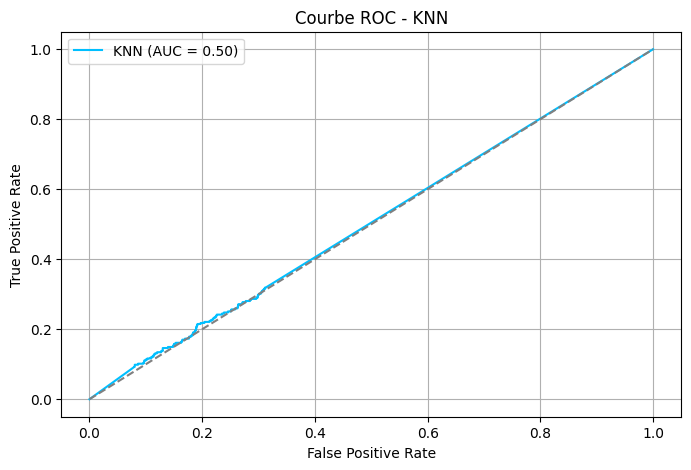

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities from KNN model
y_scores = knn.predict_proba(X_test_knn)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_knn, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})', color='deepskyblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - KNN")
plt.legend()
plt.grid(True)
plt.show()


Exemples de prédictions : [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


NameError: name 'y_test' is not defined

Accuracy : 0.7840421381193914
Precision: 0.06531531531531531
Recall   : 0.17313432835820897
F1 Score : 0.09484873262469337


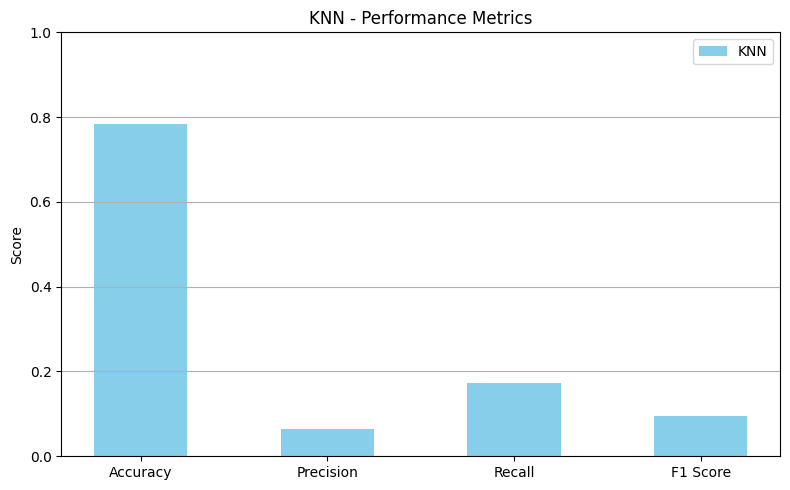

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# === KNN Scores (use y_test_knn, not y_test) ===
accuracy = accuracy_score(y_test_knn, y_pred)
precision = precision_score(y_test_knn, y_pred)
recall = recall_score(y_test_knn, y_pred)
f1 = f1_score(y_test_knn, y_pred)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

# === Bar Chart of Metrics ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
knn_scores = [accuracy, precision, recall, f1]

x = np.arange(len(metrics))
width = 0.5

plt.figure(figsize=(8, 5))
plt.bar(x, knn_scores, width, color='skyblue', label='KNN')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('KNN - Performance Metrics')
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree on non-SMOTE data
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train_tree, y_train_tree)  # clean, original training data


DecisionTreeClassifier(max_depth=5, random_state=42)

In [18]:
# Predict class labels and probabilities for Decision Tree
y_pred_tree = tree.predict(X_test_tree)
y_proba_tree = tree.predict_proba(X_test_tree)[:, 1]  # for ROC curve and AUC



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print("\n=== Decision Tree Classification Report ===")
print(classification_report(y_test_tree, y_pred_tree))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tree, y_pred_tree))

print("Accuracy :", accuracy_score(y_test_tree, y_pred_tree))
print("Precision:", precision_score(y_test_tree, y_pred_tree))
print("Recall   :", recall_score(y_test_tree, y_pred_tree))
print("F1 Score :", f1_score(y_test_tree, y_pred_tree))




=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      4791
         1.0       1.00      0.00      0.01       335

    accuracy                           0.93      5126
   macro avg       0.97      0.50      0.49      5126
weighted avg       0.94      0.93      0.90      5126


Confusion Matrix:
[[4791    0]
 [ 334    1]]
Accuracy : 0.9348419820522825
Precision: 1.0
Recall   : 0.0029850746268656717
F1 Score : 0.005952380952380952


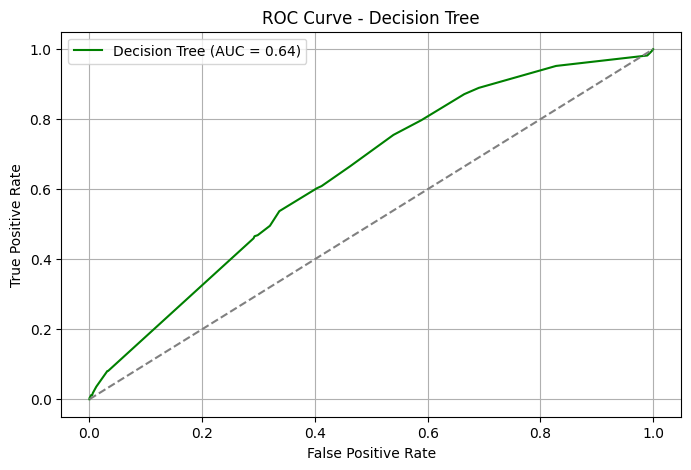

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC using correct test labels
fpr, tpr, _ = roc_curve(y_test_tree, y_proba_tree)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()



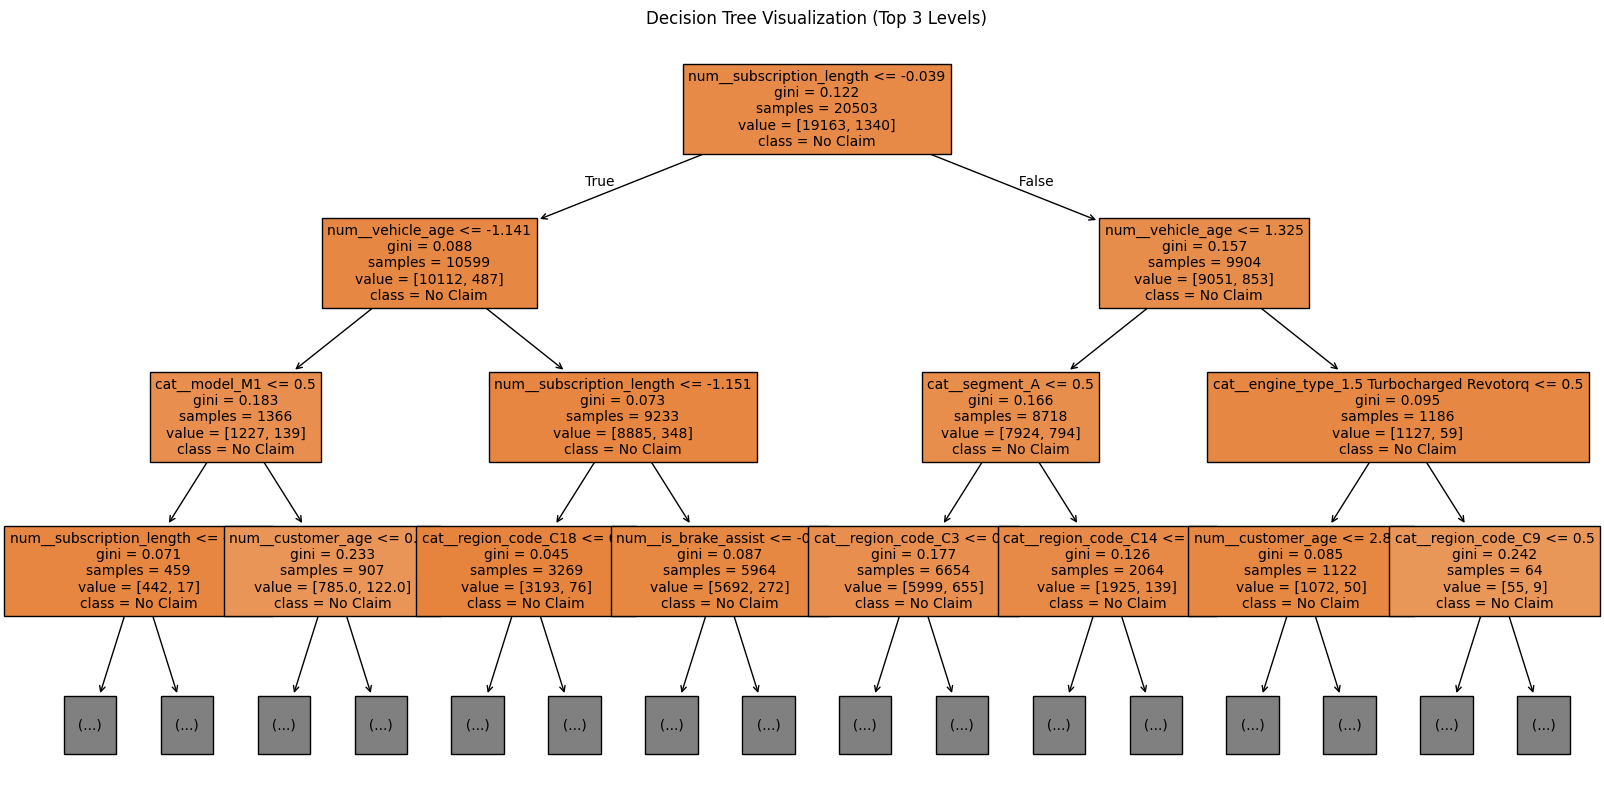

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    filled=True,
    max_depth=3,  # Only show the top 3 levels of the tree
    fontsize=10,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=["No Claim", "Claim"]
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()




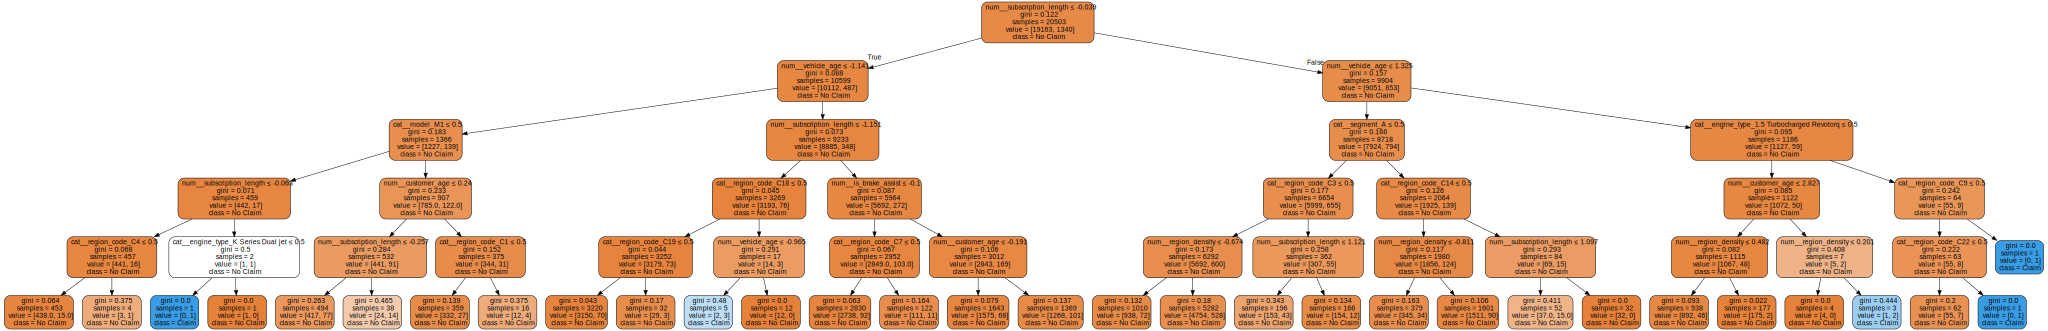

In [22]:
from sklearn.tree import export_graphviz
import graphviz

# Export decision tree as DOT format
dot_data = export_graphviz(
    tree,  # use your trained DecisionTreeClassifier
    out_file=None,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['No Claim', 'Claim'],
    filled=True,
    rounded=True,
    special_characters=True,
)

# Render and display the tree
graph = graphviz.Source(dot_data)
graph.render("decision_tree_graphviz", format="png", cleanup=True)  # Saves the tree as PNG
graph  # Renders directly if you're in Jupyter/Colab



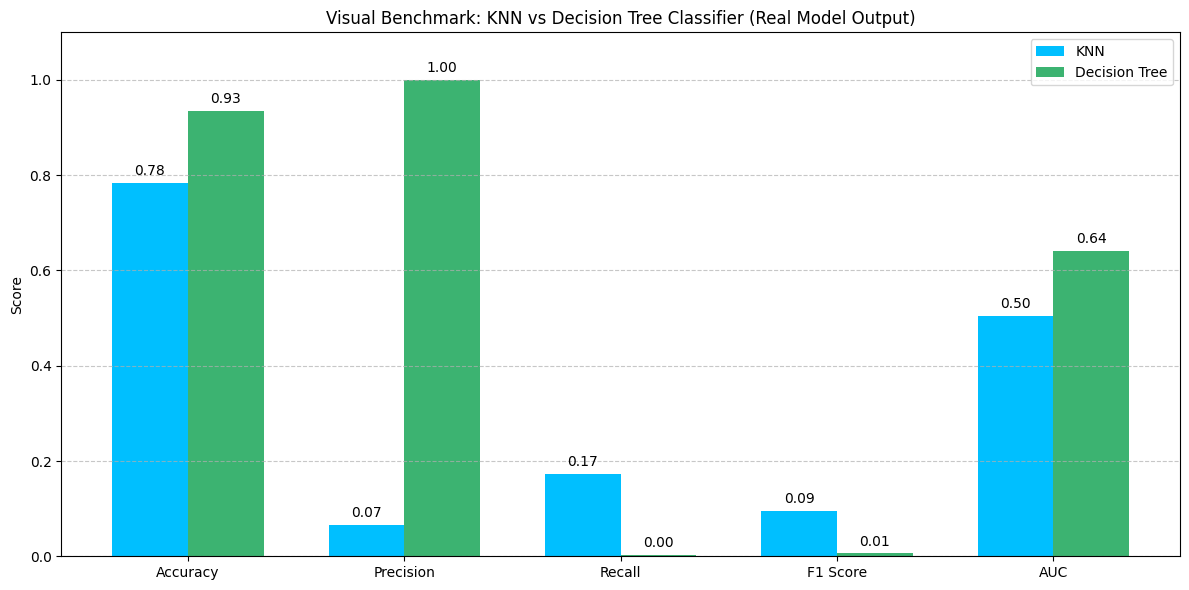

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Redefine the scoring based on correctly matched test sets
actual_knn_scores = {
    'Accuracy': accuracy_score(y_test_knn, y_pred),
    'Precision': precision_score(y_test_knn, y_pred),
    'Recall': recall_score(y_test_knn, y_pred),
    'F1 Score': f1_score(y_test_knn, y_pred),
    'AUC': roc_auc_score(y_test_knn, y_scores)
}

actual_tree_scores = {
    'Accuracy': accuracy_score(y_test_tree, y_pred_tree),
    'Precision': precision_score(y_test_tree, y_pred_tree),
    'Recall': recall_score(y_test_tree, y_pred_tree),
    'F1 Score': f1_score(y_test_tree, y_pred_tree),
    'AUC': roc_auc_score(y_test_tree, y_proba_tree)
}

# Extract for plotting
metrics = list(actual_knn_scores.keys())
knn_values = list(actual_knn_scores.values())
tree_values = list(actual_tree_scores.values())

x = np.arange(len(metrics))
width = 0.35

# Plotting
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, knn_values, width, label='KNN', color='deepskyblue')
bars2 = plt.bar(x + width/2, tree_values, width, label='Decision Tree', color='mediumseagreen')

# Annotate bars
for i, val in enumerate(knn_values):
    plt.text(x[i] - width/2, val + 0.01, f'{val:.2f}', ha='center', va='bottom')
for i, val in enumerate(tree_values):
    plt.text(x[i] + width/2, val + 0.01, f'{val:.2f}', ha='center', va='bottom')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Visual Benchmark: KNN vs Decision Tree Classifier (Real Model Output)')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


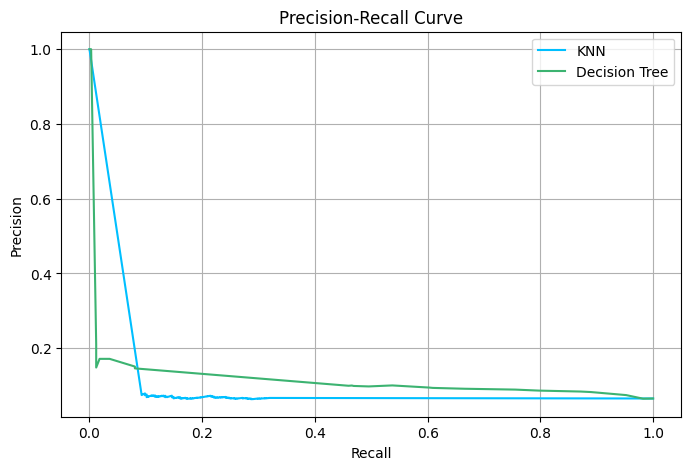

In [24]:
from sklearn.metrics import precision_recall_curve

precision_knn, recall_knn, _ = precision_recall_curve(y_test_knn, y_scores)
precision_tree, recall_tree, _ = precision_recall_curve(y_test_tree, y_proba_tree)

plt.figure(figsize=(8, 5))
plt.plot(recall_knn, precision_knn, label='KNN', color='deepskyblue')
plt.plot(recall_tree, precision_tree, label='Decision Tree', color='mediumseagreen')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


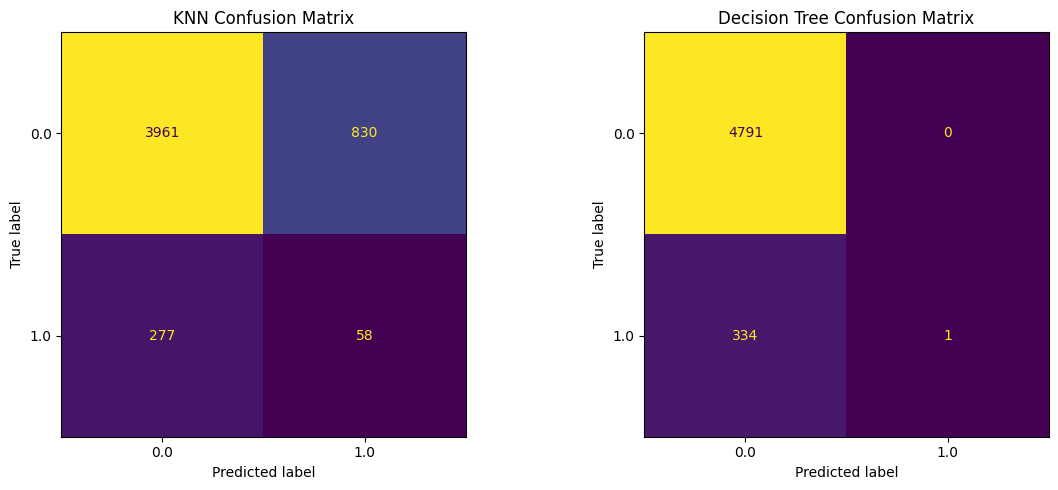

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test_knn, y_pred, ax=axes[0], colorbar=False)
axes[0].set_title("KNN Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_test_tree, y_pred_tree, ax=axes[1], colorbar=False)
axes[1].set_title("Decision Tree Confusion Matrix")

plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import cross_val_score

scores_knn = cross_val_score(knn, X_train_knn, y_train_knn, cv=5, scoring='f1')
scores_tree = cross_val_score(tree, X_train_tree, y_train_tree, cv=5, scoring='f1')

print("KNN F1 (CV Avg):", scores_knn.mean())
print("Tree F1 (CV Avg):", scores_tree.mean())


KeyboardInterrupt: 

In [27]:
from joblib import dump

# Assuming `knn` is your trained model
dump(knn, 'knn_model.joblib')

['knn_model.joblib']